In [1]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

In [2]:
# columns used frequently
"EXTN_TPRT", "DWP_TPRT", "EXTN_SRQT", 
"INNER_HMDT_1", "INNER_HMDT_2",
"INNER_TPRT_1", "INNER_TPRT_2"

('INNER_TPRT_1', 'INNER_TPRT_2')

# define useful functions

In [3]:
from util.log import describe_df

In [25]:
def sliding_windows(data, seq_length, x_cols=None, y_cols=None):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[x_cols].iloc[i:(i+seq_length)].to_numpy()
        _y = data[y_cols].iloc[i+seq_length].to_numpy()
        x.append(_x)
        y.append(_y)
    return (
        torch.tensor(np.array(x), dtype=torch.float32).view(-1, seq_length, len(x_cols)),
        torch.tensor(np.array(y), dtype=torch.float32).view(-1, len(y_cols))
    )

def preprocess(df, x_cols, y_cols):
    seq_length = 36
    
    x, y = sliding_windows(df, seq_length, x_cols, y_cols)
    train_size = int(y.shape[0] * 0.8)
    test_size = len(y) - train_size

    x_train, y_train = x[:train_size], y[:train_size]
    x_test, y_test = x[train_size:], y[train_size:]

    for k, v in {"total": [x, y],
                 "train": [x_train, y_train],
                 "test": [x_test, y_test]}.items():
        
        print(k, "X", v[0].shape, "Y", v[1].shape)
    # print(x.shape, y.shape)

    # dataX = Variable(torch.Tensor(np.array(x)))
    # dataY = Variable(torch.Tensor(np.array(y)))

    # trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    # trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    # testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    # testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    # print(trainX.shape, trainY.shape, testX.shape, testY.shape, sep="\n")
    # print(trainX[0], trainY[0])
    # print(trainX[1], trainY[1])
    # print((trainX[1][-1]==trainY[0]).all())

    return x_train, y_train, x_test, y_test

In [10]:
from util.model import LSTM

def train(trainX, trainY, epoch=None):
    num_epochs = epoch if epoch else 2000
    learning_rate = 0.01

    input_size = trainX.shape[-1]
    hidden_size = 4
    num_layers = 1

    num_classes = trainY.shape[-1] # output_size

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    return lstm

In [11]:
from util.log import save_model, regression_results

def eval(lstm, X, Y, line=None):
    lstm.eval()
    train_predict = lstm(X)
    # print("X dataset shape & prediction shape:", X.shape, train_predict.shape)

    predict = train_predict.data.numpy()
    Y_plot = Y.data.numpy()

    # predict = sc.inverse_transform(predict)
    # Y_plot = sc.inverse_transform(Y_plot)

    regression_results(Y_plot, predict)

    plt.figure(figsize=(15, 5)) 
    if line:
        plt.axvline(x=line, c='r', linestyle='--')
    plt.plot(Y_plot)
    plt.plot(predict, linestyle='dotted')
    plt.suptitle('Time-Series Prediction')
    plt.show()

# 5min step

In [12]:
raw_df = pd.read_csv("merged.csv", usecols=["INNER_TPRT_1", "EXTN_TPRT", "INNER_HMDT_1"])
df = raw_df[:5000]
# df["MSRM_DT"] = (pd.to_datetime(df["MSRM_DT"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

x_cols = ["INNER_TPRT_1", "EXTN_TPRT"]
y_cols = ["INNER_TPRT_1"]
# describe_df(df)

In [26]:
x_train, y_train, x_test, y_test = preprocess(df, x_cols, y_cols)

total X torch.Size([4963, 36, 2]) Y torch.Size([4963, 1])
train X torch.Size([3970, 36, 2]) Y torch.Size([3970, 1])
test X torch.Size([993, 36, 2]) Y torch.Size([993, 1])


In [44]:
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 32
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                          shuffle=True, drop_last=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                         shuffle=False, drop_last=True)

In [45]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 2000
learning_rate = 0.01

model = LSTM(num_classes = y_train.shape[-1], # output_size, 
             input_size = x_train.shape[-1], 
             hidden_size = 4, 
             num_layers = 1
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

In [46]:
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch 00013: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00017: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00033: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00038: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00048: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00059: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00063: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00067: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00071: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00075: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00079: reducing learning rate of group 0 to 4.8828e-06.
Epoch 00083: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00087: reducing learning rate of group 0 to 1.2207e-06.
Epoch 00091: reducing learning rate of group 0 to 6.1035e-07.
Epoch 00095: reducing learning rate of group 0 to 3.0518e-07.
Epoch 00099: reducing learning rate of group 0 to 1.5259e-07.
Epoch 00

In [47]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        try:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            print(outputs.shape)
            predictions.extend(outputs.squeeze().tolist())
        except:
            print(y_batch, outputs)

rmse = np.sqrt(np.mean(
    (np.array(predictions).reshape(-1, 1) - y_test.numpy().reshape(-1, 1)))**2
)
print(f"Score (RMSE): {rmse:.4f}")

torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


ValueError: operands could not be broadcast together with shapes (992,1) (993,1) 

In [14]:
lstm = train(x_train, y_train)

/home/agtech-research/문서/tomato2023/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, loss: 318.00562
Epoch: 100, loss: 172.94702
Epoch: 200, loss: 63.21997
Epoch: 300, loss: 26.01446
Epoch: 400, loss: 12.81106
Epoch: 500, loss: 8.88667
Epoch: 600, loss: 7.94466
Epoch: 700, loss: 7.76369
Epoch: 800, loss: 6.67378
Epoch: 900, loss: 4.01876
Epoch: 1000, loss: 2.55559
Epoch: 1100, loss: 1.79828
Epoch: 1200, loss: 1.31513
Epoch: 1300, loss: 0.98432
Epoch: 1400, loss: 0.75284
Epoch: 1500, loss: 0.58887
Epoch: 1600, loss: 0.47205
Epoch: 1700, loss: 0.38831
Epoch: 1800, loss: 0.32748
Epoch: 1900, loss: 0.28252


In [15]:
save_model(lstm)

parameter size: 0.000507MB
model dict size: 744


explained_variance:  0.9685
mean_squared_log_error:  0.0005
r2:  0.9678
MAE:  0.274
MSE:  0.2488
RMSE:  0.4988


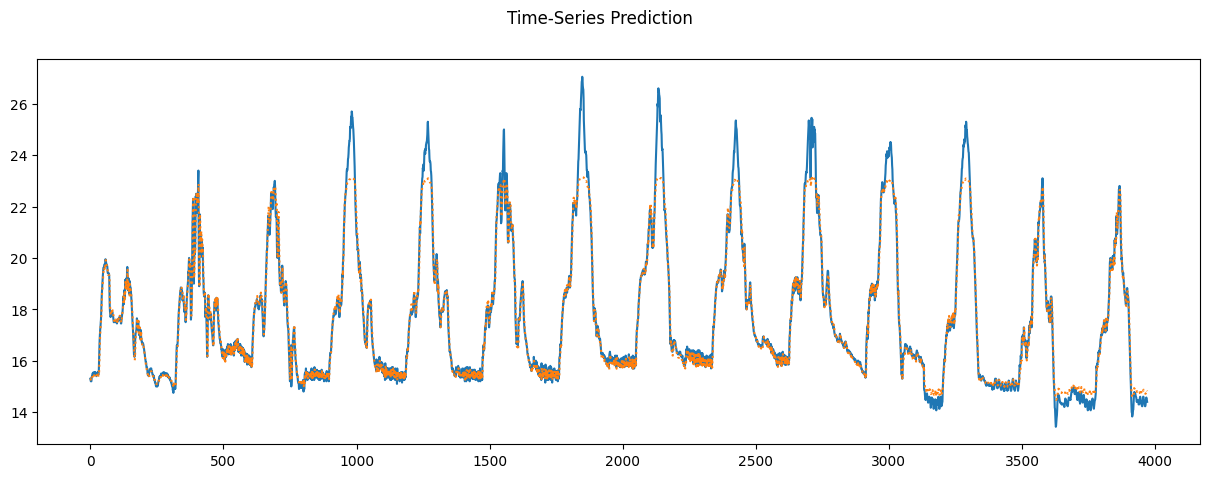

In [16]:
eval(lstm, x_train, y_train)

explained_variance:  0.9805
mean_squared_log_error:  0.0002
r2:  0.9726
MAE:  0.1943
MSE:  0.0556
RMSE:  0.2357


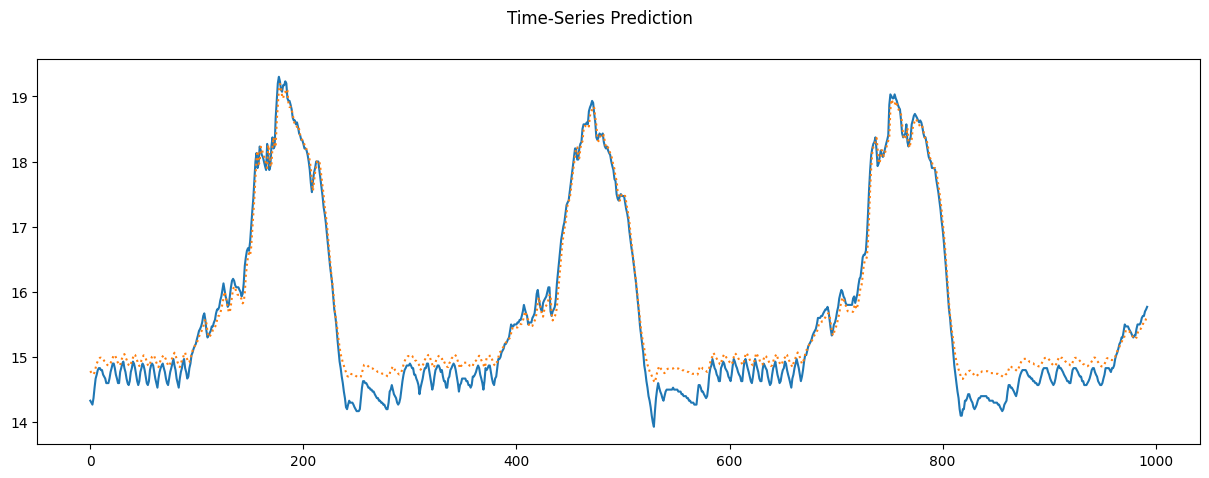

In [17]:
eval(lstm, x_test, y_test)

# 1hour step

         EXTN_TPRT  INNER_TPRT_1  INNER_HMDT_1
count  2016.000000   2016.000000   2016.000000
mean      9.876235     18.834410     81.606900
std       8.588033      4.679379     11.550811
min     -11.730000     12.030000     40.130000
25%       2.900000     14.870000     73.870000
50%       9.870000     17.600000     86.000000
75%      16.870000     21.830000     90.100000
max      31.500000     34.500000     99.100000


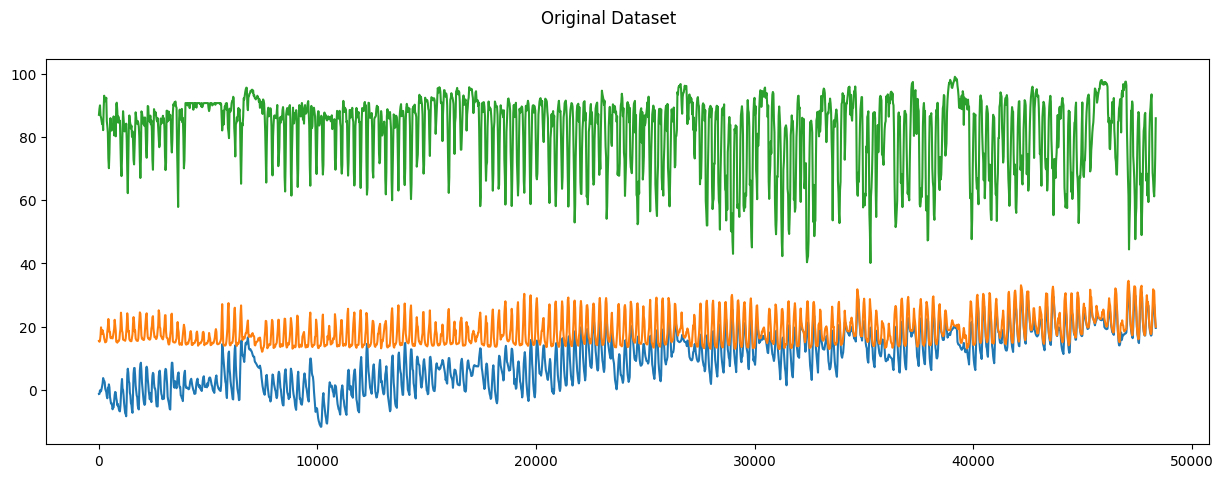

In [15]:
df1h = raw_df[::24]
describe_df(df1h)

In [16]:
train_size, sc, dataX, dataY, trainX, trainY, testX, testY = preprocess(df1h)

(1979, 36, 3) (1979, 3)
torch.Size([1583, 36, 3])
torch.Size([1583, 3])
torch.Size([396, 36, 3])
torch.Size([396, 3])
tensor([[0.2401, 0.1522, 0.7957],
        [0.2413, 0.1411, 0.8279],
        [0.2667, 0.1567, 0.8465],
        [0.2598, 0.2234, 0.7914],
        [0.2598, 0.3436, 0.7821],
        [0.2760, 0.2568, 0.7634],
        [0.2956, 0.2501, 0.7465],
        [0.3176, 0.3035, 0.7634],
        [0.3569, 0.2679, 0.7134],
        [0.3419, 0.2457, 0.8245],
        [0.3373, 0.1900, 0.8983],
        [0.3257, 0.1633, 0.8720],
        [0.2794, 0.1322, 0.8686],
        [0.2656, 0.1544, 0.8711],
        [0.2551, 0.1433, 0.8872],
        [0.2228, 0.1945, 0.7617],
        [0.2089, 0.2835, 0.7355],
        [0.2864, 0.3502, 0.6982],
        [0.2737, 0.4615, 0.5591],
        [0.3107, 0.3769, 0.5091],
        [0.2887, 0.2790, 0.5888],
        [0.2204, 0.2768, 0.7219],
        [0.1927, 0.1967, 0.7779],
        [0.1707, 0.1900, 0.7389],
        [0.1742, 0.2078, 0.7109],
        [0.1580, 0.1945, 0.7431]

In [17]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 0.35287


Epoch: 100, loss: 0.02241
Epoch: 200, loss: 0.00985
Epoch: 300, loss: 0.00677
Epoch: 400, loss: 0.00578
Epoch: 500, loss: 0.00525
Epoch: 600, loss: 0.00502
Epoch: 700, loss: 0.00485
Epoch: 800, loss: 0.00470
Epoch: 900, loss: 0.00456
Epoch: 1000, loss: 0.00442
Epoch: 1100, loss: 0.00432
Epoch: 1200, loss: 0.00423
Epoch: 1300, loss: 0.00417
Epoch: 1400, loss: 0.00424
Epoch: 1500, loss: 0.00408
Epoch: 1600, loss: 0.00425
Epoch: 1700, loss: 0.00401
Epoch: 1800, loss: 0.00397
Epoch: 1900, loss: 0.00394


In [18]:
save_model(lstm)

parameter size: 0.000607MB
model dict size: 744


X dataset shape & prediction shape: torch.Size([1979, 36, 3]) torch.Size([1979, 3])
explained_variance:  0.8922
median_absolute_error:  1.4981
r2:  0.8911
MAE:  1.9905
MSE:  9.6621
RMSE:  3.1084


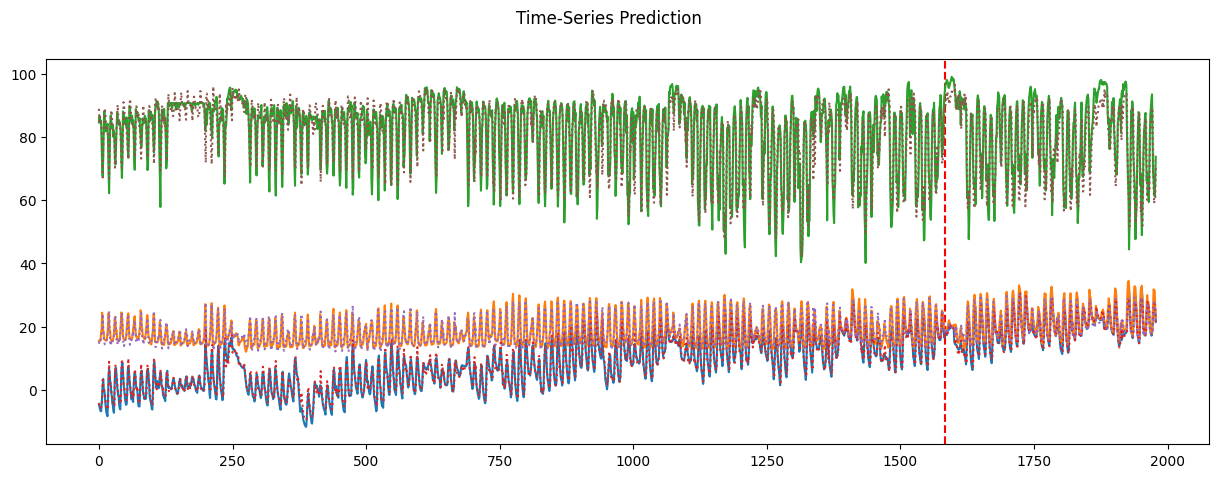

In [19]:
eval(lstm, dataX, dataY, sc, train_size)

X dataset shape & prediction shape: torch.Size([396, 36, 3]) torch.Size([396, 3])
explained_variance:  0.8701
median_absolute_error:  1.9695
r2:  0.8475
MAE:  2.3865
MSE:  12.9945
RMSE:  3.6048


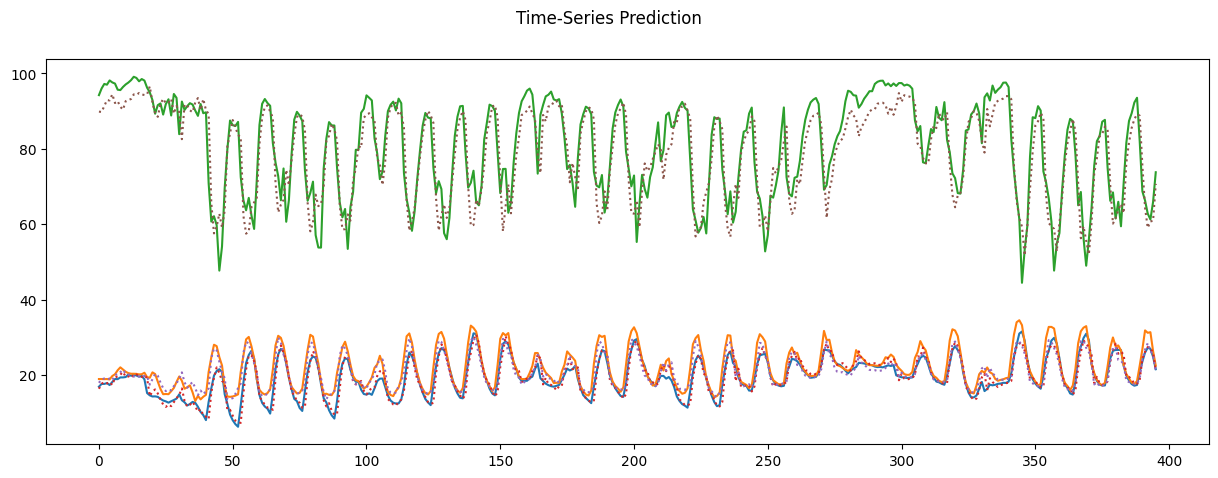

In [20]:
eval(lstm, testX, testY, sc)